In [146]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import logging
logging.basicConfig(filename='gensim.log',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.INFO)
from collections import Counter

# Data Collection

In [56]:
%run Data_Collection.ipynb

## Get New Data from website

In [3]:
chrome_driver_path = r'C:\Users\admin\Downloads\chromedriver_win32\chromedriver.exe'
fox_base_url = 'https://www.foxnews.com/category/health/infectious-disease/coronavirus'
ny_base_url = 'https://www.nytimes.com/search?query=coronavirus'
cnn_base_url = 'https://edition.cnn.com/search?q=coronavirus&size=10&from=0&page=1'
n_news = 20

In [57]:
fox_data =get_FOX_news(chrome_driver_path,fox_base_url,n_news)

In [5]:
ny_data =get_NYTimes_news(chrome_driver_path,ny_base_url,n_news)

In [6]:
cnn_data =get_CNN_news(chrome_driver_path,cnn_base_url,n_news)

In [58]:
merged_data = pd.concat([fox_data,ny_data,cnn_data],ignore_index=True)

In [59]:
merged_data.head(5)

,Published_Date,News Source,URL,Title,Category,Content
0,2020-08-23,Fox News,https://www.foxnews.com/politics/trump-to-reve...,Trump to reveal coronavirus 'breakthrough' the...,politics,Vladimir Putin claims Russia has won the race ...
1,2020-08-22,Fox News,https://www.foxnews.com/health/coronavirus-sur...,Coronavirus survivors plagued by long-term ail...,health,Heat wave brings concerns of another case spik...
2,2020-08-22,Fox News,https://www.foxnews.com/opinion/coronavirus-ma...,Gov. Asa Hutchinson: To fight coronavirus wear...,opinion,Times of challenge have always summoned the gr...
3,2020-08-22,Fox News,https://www.foxnews.com/politics/michigan-appe...,Michigan appeals court backs Whitmer's use of ...,politics,A Michigan appeals court on Friday ruled in fa...
4,2020-08-22,Fox News,https://www.foxnews.com/us/students-demand-tui...,Students demand tuition cuts as more colleges ...,us,Universities are cracking down as campuses see...


## Handling duplicate news

In [60]:
Counter(merged_data.Title).most_common(10)

[('Mysterious Coronavirus Outbreak Catches Vietnam by Surprise', 2),
 ('Robert O’Brien, Trump’s National Security Adviser, Has the Virus', 2),
 ('Coronavirus update: Latest news from around the world', 2),
 ('Opinion: The Republican Party has a tough choice to make', 2),
 ('New Zealand PM Jacinda Ardern delays election over Covid-19', 2),
 ("Trump to reveal coronavirus 'breakthrough' therapeutic, WH press secretary says",
  1),
 ('Coronavirus survivors plagued by long-term ailments', 1),
 ('Gov. Asa Hutchinson: To fight coronavirus wear a mask — new survey shows most Americans agree',
  1),
 ("Michigan appeals court backs Whitmer's use of emergency powers amid coronavirus pandemic",
  1),
 ('Students demand tuition cuts as more colleges pivot to virtual learning',
  1)]

In [61]:
merged_data.drop_duplicates(subset ="Title", 
                     keep = "first", inplace = True) 

## Handling missing data

In [62]:
merged_data2 = merged_data[merged_data.Content != ""]

## Save the result for future use

In [64]:
#merged_data2.to_pickle("data_20200823.pkl")

## Get Previous Data

In [133]:
merged_data2 = pd.read_pickle("data_20200823.pkl")

In [134]:
len(merged_data2)

1361

## Checking the distribution of category

In [135]:
merged_data2.Category.unique()

array(['politics', 'health', 'opinion', 'us', 'world', 'sports',
       'lifestyle', 'faith-values', 'entertainment', 'media',
       'food-drink', 'travel', 'great-outdoors', 'auto', 'technology',
       'parenting', 'business', 'reader-center', 'arts', 'your-money',
       'nyregion', 'science', 'movies', 'climate', 'theater', 'style',
       'podcasts', 'tech', 'asia', 'opinions', 'sport',
       'app-news-section', 'americas', 'europe', 'success',
       'perspectives', 'cnn10', 'investing', 'economy', 'football',
       'australia', 'africa', 'uk', 'weather', 'golf', 'middleeast',
       'motorsport', 'tennis'], dtype=object)

In [136]:
len(merged_data2.Category.unique())

48

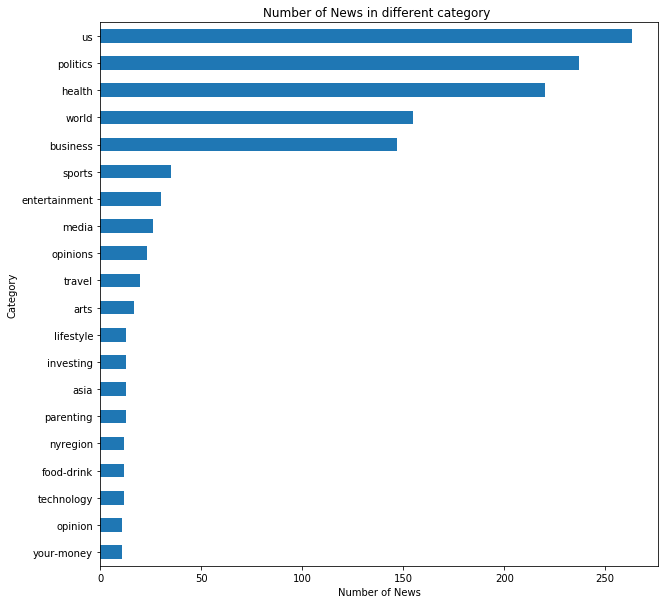

In [137]:
fig, ax = plt.subplots(figsize=(10, 10))
bar_chart = merged_data2['Category'].value_counts(ascending =True)[-20:].plot(kind='barh',title = 'Number of News in different category ')
bar_chart.set(xlabel="Number of News", ylabel="Category")
bar_chart

# Text Cleaning

In [138]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
def textPrecessing(text):
    text = text.lower()
    text = " ".join([word for word in text.split(" ") if not word.startswith("http")])
    text = re.sub('[^A-Za-z ]+', '', text)

    wordLst = nltk.word_tokenize(text)
    stop_words = stopwords.words('english')
    #word that found inrelevant when evaluation
    stop_words.extend(['said','would','also','say','says','saying'])
    filtered = [w for w in wordLst if w not in stop_words]

    ps = PorterStemmer()
    filtered = [ps.stem(w) for w in filtered]

    return " ".join(filtered)

In [139]:
output = [textPrecessing(doc) for doc in merged_data2.Content]

# Apply LDA in gensim

In [140]:
import gensim
from gensim.models import CoherenceModel
# Build the bigram and trigram models
data_words= [document.split(" ") for document in output]
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

D:\Anaconda\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [141]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [142]:
data_words_bigrams = make_bigrams(data_words)

In [143]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)
# Create Corpus
texts = data_words_bigrams
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [144]:
def get_coherent_value(data,corpus,ld2word,num_passes,num_iter, num_topic,a,b):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topic, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=num_passes,
                                       iterations= num_iter,
                                       alpha=a,
                                       eta=b,
                                       per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return(coherence_lda)

In [145]:
import numpy as np
import pandas as pd

## Base model using default alpha (1/num_topics) and default eta (1/num_words) ,passes=20, iteration =500   

In [155]:
# Build LDA model
base_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=20,
                                       iterations =500,
                                       per_word_topics=True)

## Determine the number of topic based on the coherence value by coherence model. 

In [156]:
coherence_scores =[]

for num_topic in range(2,40,4):
    value=get_coherent_value(data_words_bigrams,corpus,id2word,20,500,num_topic,'symmetric','symmetric')
    coherence_scores.append(value)

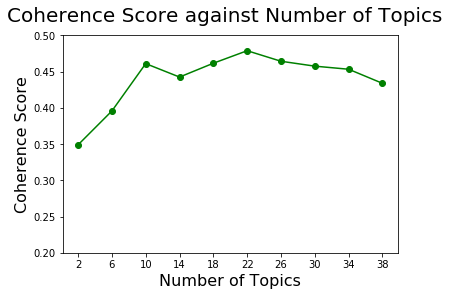

In [157]:
from matplotlib import pylab as plt
fig = plt.figure()

plt.plot(coherence_scores, 'go-')
plt.ylim(0.2, 0.5)
plt.xticks(range(10), range(2,40,4))
fig.suptitle('Coherence Score against Number of Topics', fontsize=20)
plt.xlabel('Number of Topics', fontsize=16)
plt.ylabel('Coherence Score', fontsize=16)
plt.show()

## Base model with optimized number of topics

In [158]:
# Build LDA model
base_model2 = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=20,
                                       iterations =500,
                                       per_word_topics=True)

In [159]:
#using auto to learn the prior probability from data
auto_model =gensim.models.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=20,
                                       iterations =500,
                                       alpha='auto',
                                       eta='auto',
                                       per_word_topics=True)

In [160]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=base_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.46856296343762394


In [161]:

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=base_model2, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4659991827835633


In [162]:

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=auto_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.45815842467204926


In [168]:
keywords = base_model2.show_topics(num_topics=10,formatted=False)
keywords.sort(key=lambda tup: tup[0])
keywords_list = []
for a,b in keywords:
    words = [c for c,d in b]
    keywords_list.append(words)

In [169]:
keywords_df = pd.DataFrame(keywords_list)

In [170]:
keywords_df.to_csv("keywords.csv")

In [166]:
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

In [167]:
dominant_topics, topic_percentages = topics_per_document(model=base_model2, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])

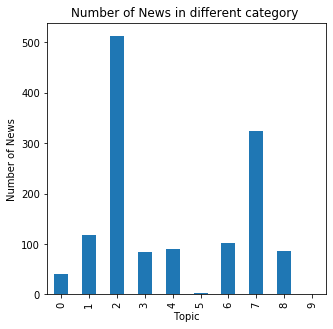

In [171]:
fig, ax = plt.subplots(figsize=(5, 5))
bar_chart = df['Dominant_Topic'].value_counts(sort =False).plot(kind='bar',title = 'Number of News in different category ')
bar_chart.set(xlabel="Topic", ylabel="Number of News")
bar_chart

In [172]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(base_model2, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.152189 -0.042663       1        1  38.462814
7     -0.130089 -0.034131       2        1  25.873533
4     -0.074191 -0.088894       3        1   7.826504
1     -0.120649  0.140668       4        1   7.147908
6     -0.071239 -0.138434       5        1   5.630234
3     -0.046015  0.133741       6        1   5.359298
0     -0.037695  0.100060       7        1   4.035296
8     -0.009120 -0.062999       8        1   3.619771
5      0.303835 -0.042122       9        1   1.201120
9      0.337351  0.034773      10        1   0.843527, topic_info=         Term         Freq        Total Category  logprob  loglift
424    school  2910.000000  2910.000000  Default  30.0000  30.0000
168    vaccin  1620.000000  1620.000000  Default  29.0000  29.0000
161     trump  2782.000000  2782.000000  Default  28.0000  28.0000
754   student  1356.000000  1356.000000  Default  27.0000  27.0000
113    presid  1999.000000  1999.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
2598  perform    14.980584   251.570923  Topic10  -6.1332   1.9544
3861    locat    12.327607   207.768845  Topic10  -6.3281   1.9507
459    tradit    11.071387   141.198196  Topic10  -6.4356   2.2295
1504    guest     9.862995    79.983688  Topic10  -6.5512   2.6823
4353  theater     9.703323   110.287941  Topic10  -6.5675   2.3447

[782 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
23959      5  0.966620      aap
25922      6  0.961504     abba
2157       1  0.984131   abbott
52700      3  0.981078     abpa
4816       2  0.013414  absente
...      ...       ...      ...
50095      9  0.884599     yuni
37287     10  0.804167   zamora
52297      6  0.984481      zay
8450       1  0.940274  zealand
8450       2  0.058767  zealand

[2075 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 8, 5, 2, 7, 4, 1, 9, 6, 10])

In [173]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(base_model2.print_topics())

[(0,
  '0.035*"vaccin" + 0.010*"trump" + 0.007*"presid" + 0.007*"us" + '
  '0.007*"white_hous" + 0.006*"offici" + 0.006*"church" + 0.005*"coronaviru" + '
  '0.005*"one" + 0.005*"govern"'),
 (1,
  '0.019*"trump" + 0.014*"elect" + 0.012*"vote" + 0.011*"democrat" + '
  '0.011*"state" + 0.011*"republican" + 0.009*"presid" + 0.006*"voter" + '
  '0.006*"senat" + 0.006*"want"'),
 (2,
  '0.010*"test" + 0.010*"case" + 0.010*"state" + 0.010*"health" + '
  '0.009*"peopl" + 0.008*"coronaviru" + 0.008*"new" + 0.007*"viru" + '
  '0.006*"countri" + 0.005*"report"'),
 (3,
  '0.015*"biden" + 0.011*"presid" + 0.011*"trump" + 0.008*"convent" + '
  '0.007*"democrat" + 0.005*"speech" + 0.005*"parti" + 0.005*"us" + '
  '0.005*"harri" + 0.005*"night"'),
 (4,
  '0.009*"viru" + 0.008*"peopl" + 0.007*"like" + 0.006*"mask" + 0.006*"covid" '
  '+ 0.005*"coronaviru" + 0.005*"food" + 0.005*"go" + 0.005*"infect" + '
  '0.005*"get"'),
 (5,
  '0.008*"ibm" + 0.007*"flower" + 0.006*"compani" + 0.006*"nevada" + '
  '0.00